<a href="https://colab.research.google.com/github/tummalapallimurali/Algorithms/blob/main/Machine_Abnormality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$ y= a + b x + c x^2 + d^3 $ \
$ loss = (y-y_{pred})^2 /2 $

In [1]:
#@title Gradient descent testing

# Gradient descent weights for a function

import numpy as np
import math

# random inputs
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# initialize weights

a = np.random.rand()
b = np.random.rand()
c = np.random.rand()
d = np.random.rand()

# y = a + b x + c x^2 + d x^3

#y_pred = a + b * x + c * x^2 + d * x ^ 3

learning_rate = 0.001

# forward pass

for i in range(100):
  y_pred = a + b * x + c * x**2 + d * x**3
  loss = np.square(np.subtract(y, y_pred)).mean()

  # back prop to update weights w.r.t loss

  grad_y_pred = 2 * (y - y_pred)
  grad_a = grad_y_pred.mean()
  grad_b = (grad_y_pred * x).mean()
  grad_c = (grad_y_pred * x**2).mean()
  grad_d = (grad_y_pred * x**3).mean()

  # update weights
  a -= learning_rate * grad_a
  b -= learning_rate * grad_b
  c -= learning_rate * grad_c
  d -= learning_rate * grad_d

print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')







Result: y = 7.063523849385443 + 5417037490.335008 x + 39.53107419798766 x^2 + 38083438479.50105 x^3


In [2]:
import requests
import json
import shutil
import os
import torch
import torchaudio


import torchaudio.transforms as T
import numpy
import sys
from matplotlib import pyplot as plt


# Analyze Audio Files: We will choose Fan recordings

In [3]:
#@title Get zip files from zenodo , extract and store in drive

directory = '/content/drive/MyDrive/GenAI Course/Data Set'

if not os.path.exists(directory):
  download_link = "https://zenodo.org/records/3384388/files/-6_dB_fan.zip?download=1"
  response = requests.get(download_link, stream=True)
  with open("-6_dB_fan.zip", "wb") as f:
    for chunk in response.iter_content(chunk_size=1024):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)
  !unzip /content/-6_dB_fan.zip
  shutil.move('/content/fan', '/content/drive/MyDrive/GenAI Course/Data Set')
else:
  print("folder already exists")

sample_wav_abn = directory + '/fan/id_00/abnormal/00000000.wav'
sample_wav_nor = directory + '/fan/id_00/normal/00000000.wav'
metadata = torchaudio.info(sample_wav_abn)

print("metadata for abnormal", metadata)

metadata = torchaudio.info(sample_wav_nor)

print("metadata for normal", metadata)




folder already exists
metadata for abnormal AudioMetaData(sample_rate=16000, num_frames=160000, num_channels=8, bits_per_sample=16, encoding=PCM_S)
metadata for normal AudioMetaData(sample_rate=16000, num_frames=160000, num_channels=8, bits_per_sample=16, encoding=PCM_S)


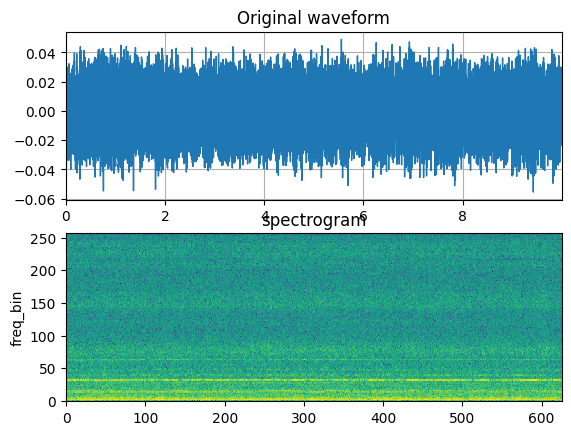

In [4]:
'''
This block of code, reads the wave form of audio and extracts the spectrogram.

https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

'''

import matplotlib.pyplot as plt
import librosa
import torch
import torchaudio.transforms as T

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


waveform, sample_rate = torchaudio.load(sample_wav_abn)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(waveform)

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[7], title="spectrogram", ax=axs[1])
#fig.tight_layout()
from IPython.display import Audio
Audio(waveform.numpy(), rate=sample_rate)


# Data Preperation

In [5]:
#@title get_files_and_labels
%%writefile utils.py

import os

def get_files_and_labels(directory):
    """
    Gets the file paths and labels for normal and abnormal audio files.

    Args:
        directory: The root directory containing machine ID folders and subfolders.

    Returns:
        A tuple containing six lists:
            files: A list of file paths for all audio files.
            labels: A list of labels (0 for normal, 1 for abnormal) corresponding to the files.
            normal_files: A list of file paths for normal audio files.
            normal_labels: A list of labels for normal audio files.
            abnormal_files: A list of file paths for abnormal audio files.
            abnormal_labels: A list of labels for abnormal audio files.
    """

    files = []
    labels = []

    # Iterate through machine ID folders and subfolders
    for machine_id in os.listdir(directory):
        machine_dir = os.path.join(directory, machine_id)
        for subfolder in ['normal', 'abnormal']:
            subfolder_dir = os.path.join(machine_dir, subfolder)

            # Check if the subfolder exists
            if os.path.isdir(subfolder_dir):
                # Iterate through files in the subfolder
                for filename in os.listdir(subfolder_dir):
                    if filename.endswith('.wav'):  # Assuming your files are WAV files
                        file_path = os.path.join(subfolder_dir, filename)
                        files.append(file_path)
                        labels.append(0 if subfolder == 'normal' else 1)  # Assign labels

    # Separate files and labels into normal and abnormal sets
    normal_files = [files[i] for i in range(len(files)) if labels[i] == 0]
    normal_labels = [0] * len(normal_files)  # All normal labels are 0
    abnormal_files = [files[i] for i in range(len(files)) if labels[i] == 1]
    abnormal_labels = [1] * len(abnormal_files)  # All abnormal labels are 1

    return files, labels, normal_files, normal_labels, abnormal_files, abnormal_labels

# Example usage:
directory = '/content/drive/MyDrive/GenAI Course/Data Set/fan'
files, labels, normal_files, normal_labels, abnormal_files, abnormal_labels = get_files_and_labels(directory)


# training files and evaluation files

train_files = normal_files[len(abnormal_files):]
train_labels = normal_labels[len(abnormal_files):]
eval_files = abnormal_files + normal_files[:len(abnormal_files)]
eval_labels = abnormal_labels + normal_labels[:len(abnormal_files)]

print("train_file num : {num}".format(num=len(train_files)))
print("eval_file  num : {num}".format(num=len(eval_files)))

def prepare_data(directory):
  _ , _, normal_files, normal_labels, abnormal_files, abnormal_labels = get_files_and_labels(directory)
  train_files = normal_files[len(abnormal_files):]
  train_labels = normal_labels[len(abnormal_files):]
  eval_files = abnormal_files + normal_files[:len(abnormal_files)]
  eval_labels = abnormal_labels + normal_labels[:len(abnormal_files)]
  return train_files, train_labels, eval_files, eval_labels

training_files, training_labels, evalu_files, evalU_labels = prepare_data(directory)





Writing utils.py


* There are 5500 total files (4075 normal(74%) and 1475(36%) abnormal samples)
* These are unbalanced samples, to keep the balance training files contained (2600) samples and eval files contains 2950.
* Training file contains only Normal files and Eval file contains normal and abnromal files.

In [6]:
# convert this to a function for each training fil
def dataset_prep(training_files, n_mels=64, frames=5, n_fft=1024, hop_length=512, power=2.0):
  dims = n_mels * frames
  for i in range(len(training_files)):
    waveform, sample_rate = torchaudio.load(training_files[i])
    melspec = T.MelSpectrogram(sample_rate, n_fft=1024,hop_length=512, n_mels=64,power=2.0)
    spec = melspec(waveform)
    log = 20.0 / power * numpy.log10(spec + sys.float_info.epsilon)
    vector_size = log.shape[2] - frames + 1
    vectorarray = numpy.zeros((vector_size, dims), float)
    for t in range(frames):
      vectorarray[:, n_mels * t: n_mels * (t + 1)] = log[0,:, t: t + vector_size].T
    dataset = numpy.zeros((vector_size * len(training_files[0]), dims), float)
    dataset[vectorarray.shape[0] * i: vectorarray.shape[0] * (i + 1), :] = vectorarray
    return dataset


In [23]:
#@title encode-decoder.py
%%writefile encode-decoder.py

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class AnomolyDetector(Model):
    def __init__(self, input_shape): # Add input_shape parameter
        super(AnomolyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(input_shape, activation="sigmoid") # Use input_shape for output layer
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Overwriting encode-decoder.py


In [8]:
#@title visalizer.py
%%writefile visualizer.py

class visualizer(object):
    def __init__(self):
        import matplotlib.pyplot as plt
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss, val_loss):
        """
        Plot loss curve.

        loss : list [ float ]
            training loss time series.
        val_loss : list [ float ]
            validation loss time series.

        return   : None
        """
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        ax.plot(val_loss)
        ax.set_title("Model loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Test"], loc="upper right")

Writing visualizer.py


In [9]:
#@title datapreprocessing.py
%%writefile datapreprocessing.py

import tqdm
import logging
import sys
import os
import glob
import librosa
import numpy

def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))

def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, numpy.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')

def file_to_vector_array(file_name,
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, fearture_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * numpy.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vectorarray_size = len(log_mel_spectrogram[0, :]) - frames + 1

    # 05 skip too short clips
    if vectorarray_size < 1:
        return numpy.empty((0, dims), float)

    # 06 generate feature vectors by concatenating multi_frames
    vectorarray = numpy.zeros((vectorarray_size, dims), float)
    for t in range(frames):
        vectorarray[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vectorarray_size].T

    return vectorarray

def list_to_vector_array(file_list,
                         msg="calc...",
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert the file_list to a vector array.
    file_to_vector_array() is iterated, and the output vector array is concatenated.

    file_list : list [ str ]
        .wav filename list of dataset
    msg : str ( default = "calc..." )
        description for tqdm.
        this parameter will be input into "desc" param at tqdm.

    return : numpy.array( numpy.array( float ) )
        training dataset (when generate the validation data, this function is not used.)
        * dataset.shape = (total_dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 loop of file_to_vectorarray
    for idx in tqdm.tqdm(range(len(file_list)), desc=msg):

        vector_array = file_to_vector_array(file_list[idx],
                                            n_mels=n_mels,
                                            frames=frames,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            power=power)

        if idx == 0:
            dataset = numpy.zeros((vector_array.shape[0] * len(file_list), dims), float)

        dataset[vector_array.shape[0] * idx: vector_array.shape[0] * (idx + 1), :] = vector_array

    return dataset




Writing datapreprocessing.py


In [10]:
#@title datasetgenerator.py(Returns training, test and evaluations labels)
%%writefile datasetgenerator.py

import logging
import sys
import os
import glob
import numpy
import random

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def dataset_generator(target_dir,
                      normal_dir_name="normal",
                      abnormal_dir_name="abnormal",
                      ext="wav"):
    """
    target_dir : str
        base directory path of the dataset
    normal_dir_name : str (default="normal")
        directory name the normal data located in
    abnormal_dir_name : str (default="abnormal")
        directory name the abnormal data located in
    ext : str (default="wav")
        filename extension of audio files

    return :
        train_data : numpy.array( numpy.array( float ) )
            training dataset
            * dataset.shape = (total_dataset_size, feature_vector_length)
        train_files : list [ str ]
            file list for training
        train_labels : list [ boolean ]
            label info. list for training
            * normal/abnormal = 0/1
        eval_files : list [ str ]
            file list for evaluation
        eval_labels : list [ boolean ]
            label info. list for evaluation
            * normal/abnormal = 0/1
    """
    logger.info("target_dir : {}".format(target_dir))

    # 01 normal list generate
    normal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{normal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                 normal_dir_name=normal_dir_name,
                                                                 ext=ext))))
    normal_labels = numpy.zeros(len(normal_files))
    if len(normal_files) == 0:
        logger.exception("no_wav_data!!")

    # 02 abnormal list generate
    abnormal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{abnormal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                   abnormal_dir_name=abnormal_dir_name,
                                                                   ext=ext))))
    abnormal_labels = numpy.ones(len(abnormal_files))
    if len(abnormal_files) == 0:
        logger.exception("no_wav_data!!")

    # 03 separate train & eval
    train_files = normal_files[len(abnormal_files):]
    train_labels = normal_labels[len(abnormal_files):]
    eval_files = numpy.concatenate((normal_files[:len(abnormal_files)], abnormal_files), axis=0)
    eval_labels = numpy.concatenate((normal_labels[:len(abnormal_files)], abnormal_labels), axis=0)
    logger.info("train_file num : {num}".format(num=len(train_files)))
    logger.info("eval_file  num : {num}".format(num=len(eval_files)))

    return train_files, train_labels, eval_files, eval_labels


Writing datasetgenerator.py


In [11]:
#@title baseline model
%%writefile keras_baseline_model.py

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def keras_model(inputDim):
    """
    define the keras model
    the model based on the simple dense auto encoder (64*64*8*64*64)
    """
    inputLayer = Input(shape=(inputDim,))
    h = Dense(64, activation="relu")(inputLayer)
    h = Dense(64, activation="relu")(h)
    h = Dense(8, activation="relu")(h)
    h = Dense(64, activation="relu")(h)
    h = Dense(64, activation="relu")(h)
    h = Dense(inputDim, activation=None)(h)

    return Model(inputs=inputLayer, outputs=h)



Writing keras_baseline_model.py


In [24]:
#@title encoder-decoder model
%%writefile keras_encoder_decoder_model.py

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def keras_model(inputDim):
    """
    Defines the Keras model with separate encoder and decoder.
    """
    # Encoder
    inputLayer = Input(shape=(inputDim,))
    h = Dense(64, activation="relu")(inputLayer)
    h = Dense(64, activation="relu")(h)
    encoded = Dense(8, activation="relu")(h)  # Encoded representation

    encoder = Model(inputs=inputLayer, outputs=encoded, name="encoder")

    # Decoder
    encoded_input = Input(shape=(8,))  # Input to the decoder
    h = Dense(64, activation="relu")(encoded_input)
    h = Dense(64, activation="relu")(h)
    decoded = Dense(inputDim, activation=None)(h)  # Decoded output

    decoder = Model(inputs=encoded_input, outputs=decoded, name="decoder")

    # Autoencoder (optional, if you still need it)
    autoencoder = Model(inputs=inputLayer, outputs=decoder(encoder(inputLayer)), name="autoencoder")

    return encoder, decoder, autoencoder

Overwriting keras_encoder_decoder_model.py


In [14]:
#@title start training

from datapreprocessing import *
from datasetgenerator import *

from visualizer import visualizer

target_dir = '/content/drive/MyDrive/GenAI Course/Data Set/fan/id_06'

train_files, train_labels, eval_files, eval_labels = dataset_generator(target_dir)

train_data = list_to_vector_array(train_files, msg="train_data")
eval_data = list_to_vector_array(eval_files, msg="eval_data")


eval_data: 100%|██████████| 722/722 [03:42<00:00,  3.25it/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 320)                 │          20,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,760 (198.28 KB)

 Trainable params: 50,760 (198.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 25.8967 - val_loss: 9.7385
Epoch 2/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 7.4498 - val_loss: 8.7571
Epoch 3/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 6.7038 - val_loss: 8.2314
Epoch 4/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 6.4738 - val_loss: 8.4616
Epoch 5/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 6.3575 - val_loss: 8.1995
Epoch 6/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 6.1877 - val_loss: 7.8471
Epoch 7/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 5.9632 - val_loss: 7.7074
Epoch 8/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 5.8922 - val_loss: 7.7922
Epoch 9/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 5.8470 - val_loss: 7.6809
Epoch 10/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.8335 - val_loss: 7.5990


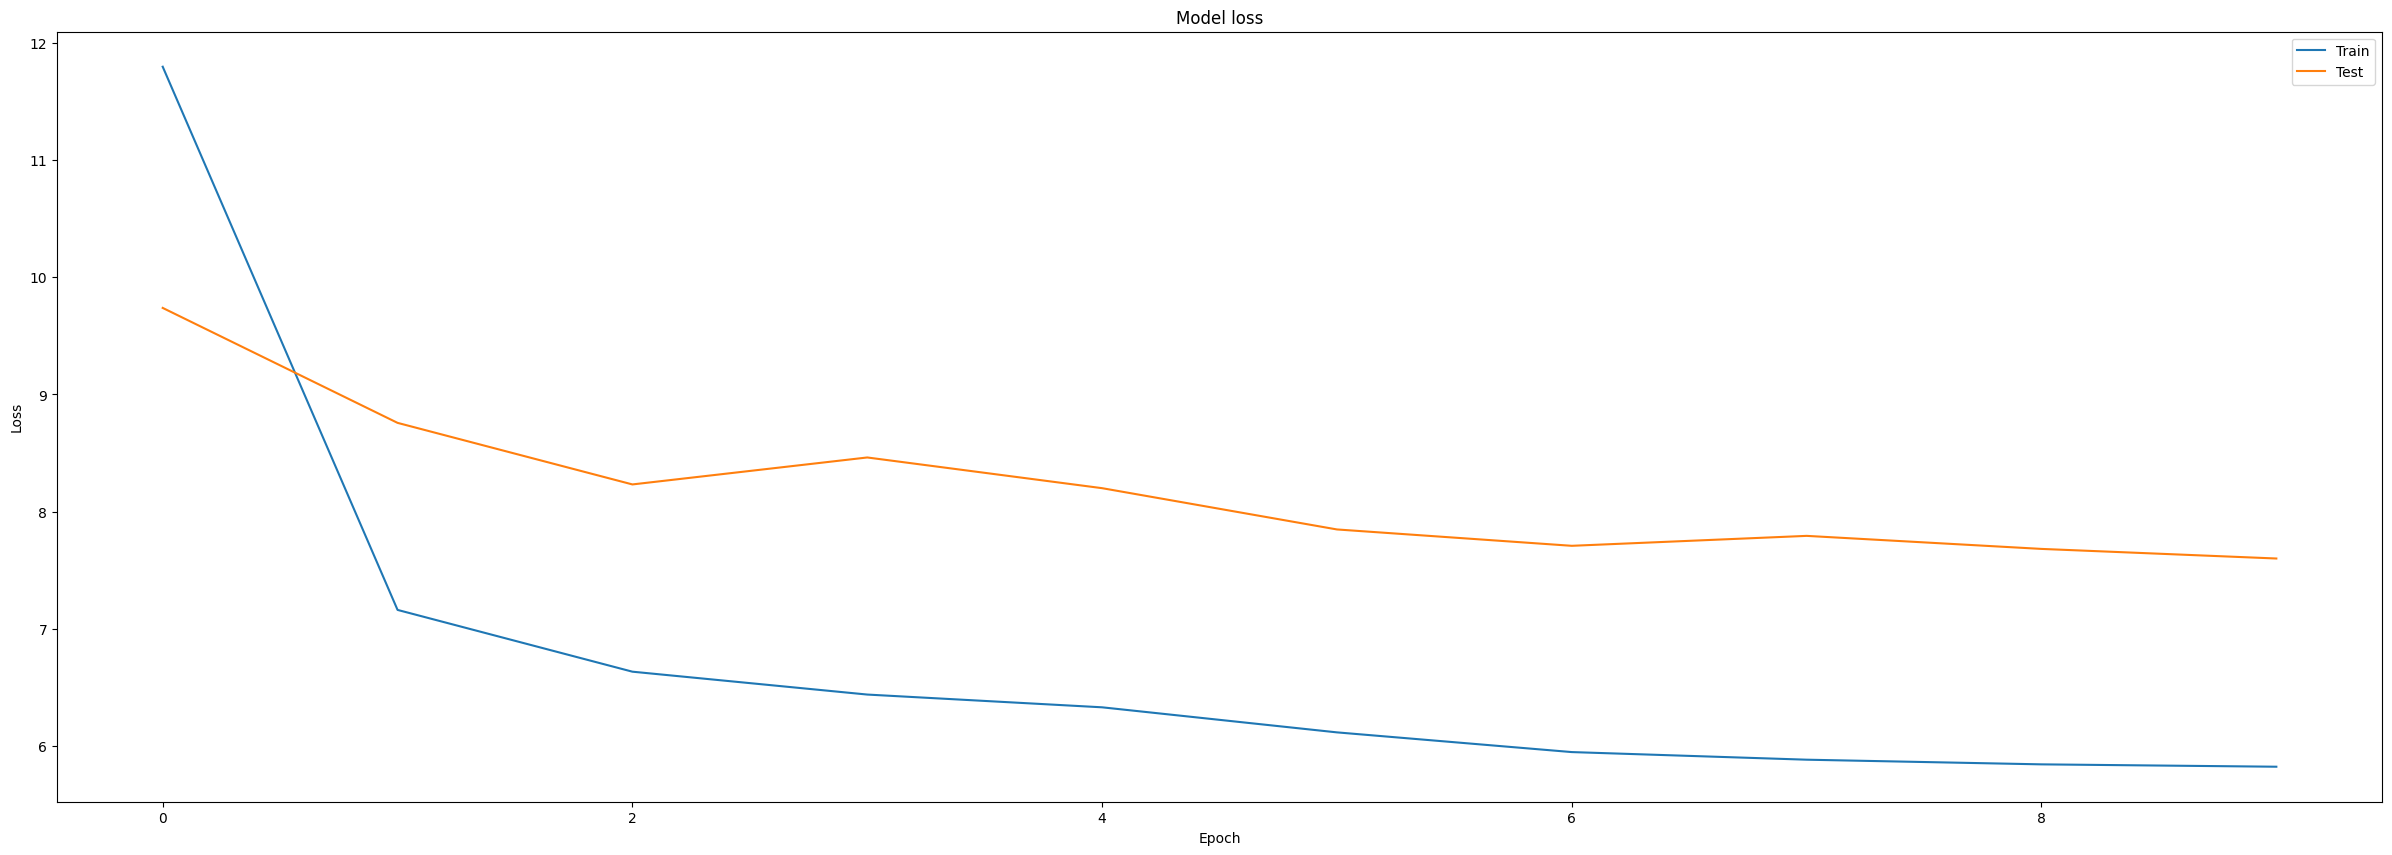

In [15]:
from keras_baseline_model import *

input_dim = train_data.shape[1]
model = keras_model(input_dim)
model.summary()

model.compile(optimizer='adam', loss='mse')
training = model.fit(train_data, train_data,
                     epochs=10,
                     batch_size=32,
                     validation_data=(eval_data, eval_data),
                     shuffle=True)

visualizer = visualizer()
visualizer.loss_plot(training.history['loss'], training.history['val_loss'])

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 8)                   │          25,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 320)                 │          25,536 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,760 (198.28 KB)

 Trainable params: 50,760 (198.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 25.7900 - val_loss: 11.0848
Epoch 2/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 8.6127 - val_loss: 10.1942
Epoch 3/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 8.2257 - val_loss: 9.7541
Epoch 4/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 7.9917 - val_loss: 9.4691
Epoch 5/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 7.3921 - val_loss: 8.6471
Epoch 6/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 6.7345 - val_loss: 8.3812
Epoch 7/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 6.5030 - val_loss: 8.6981
Epoch 8/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 6.4091 - val_loss: 8.2118
Epoch 9/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 6.3266 - val_loss: 8.2433
Epoch 10/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 6.2913 - val_loss: 8.2702


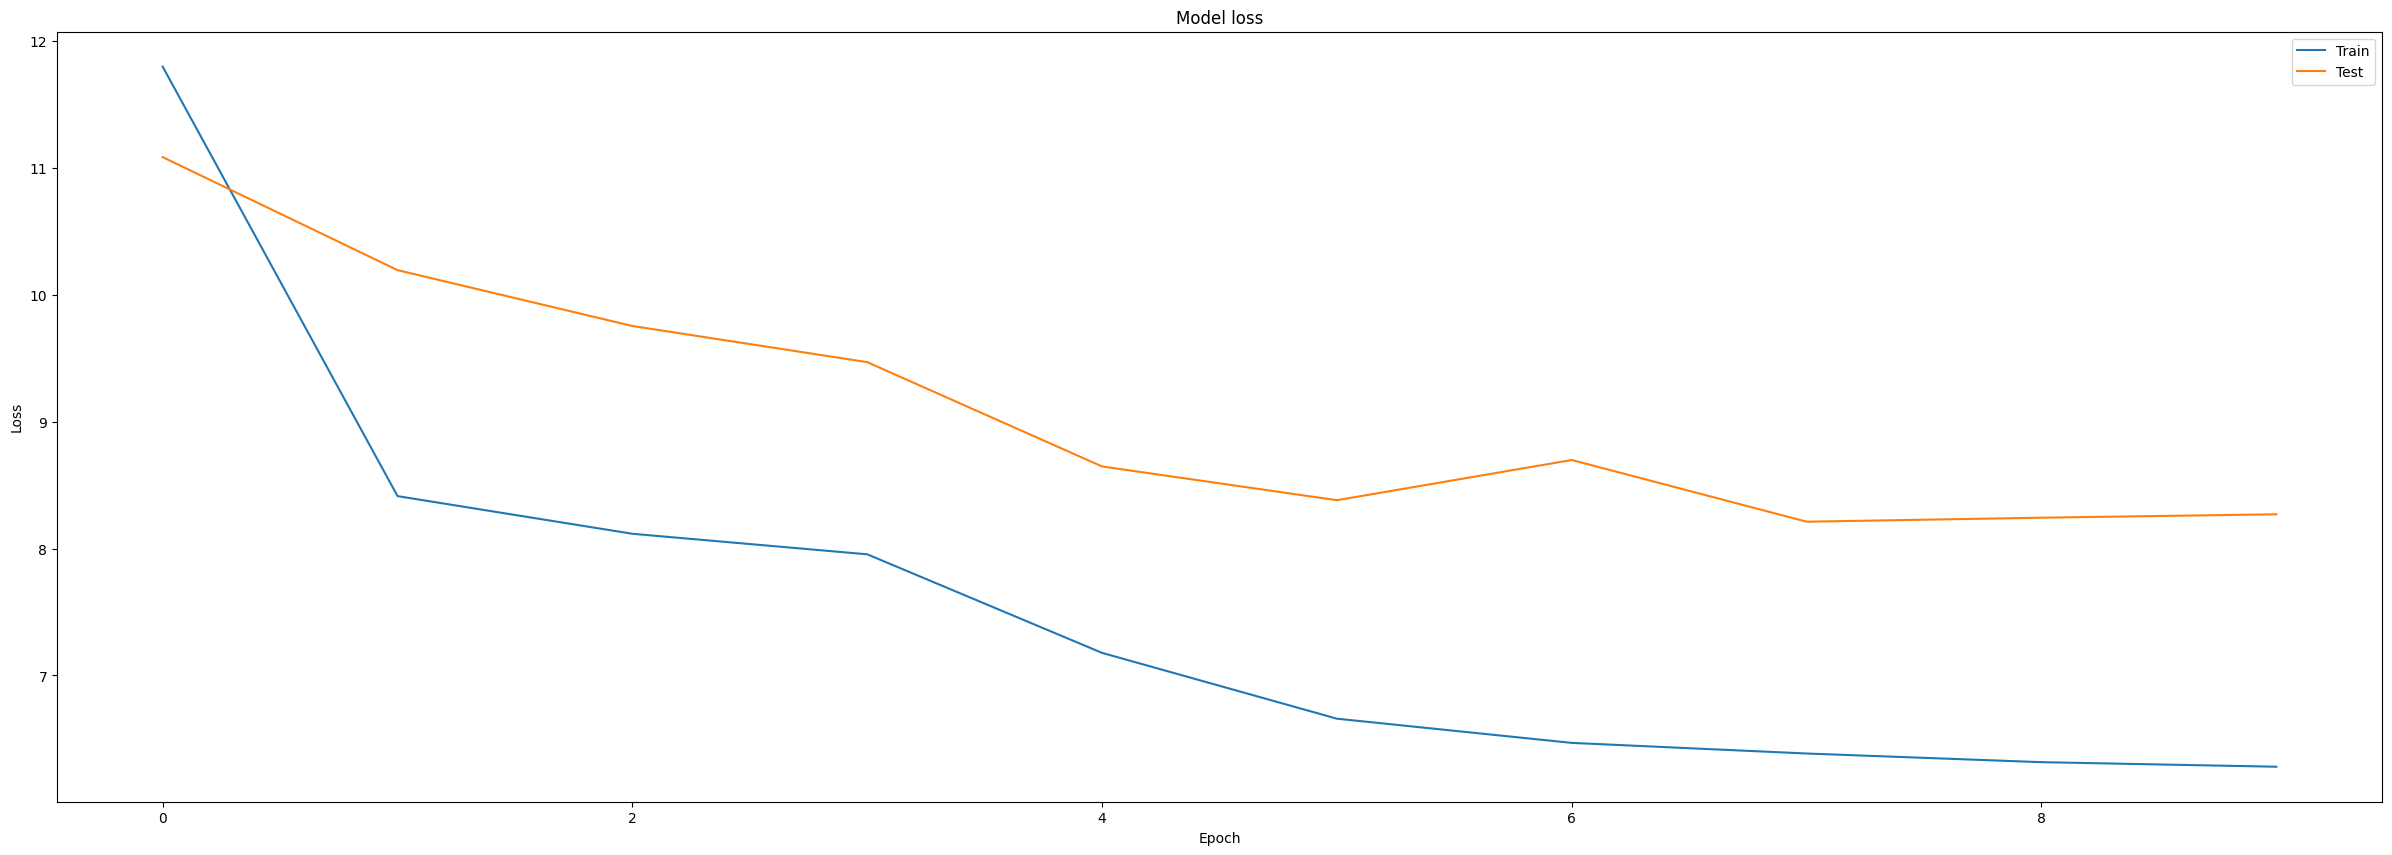

In [17]:
from keras_encoder_decoder_model import *
from visualizer import visualizer

input_dim = train_data.shape[1]
encoder, decoder, autoencoder = keras_model(input_dim)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mse') # test with loss = binary_crossentropy
history = autoencoder.fit(train_data, train_data,
                          epochs=10,
                          batch_size=32,
                          validation_data=(eval_data, eval_data),
                          shuffle=True)

visualizer = visualizer()
visualizer.loss_plot(history.history['loss'], history.history['val_loss'])

6316/6316 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


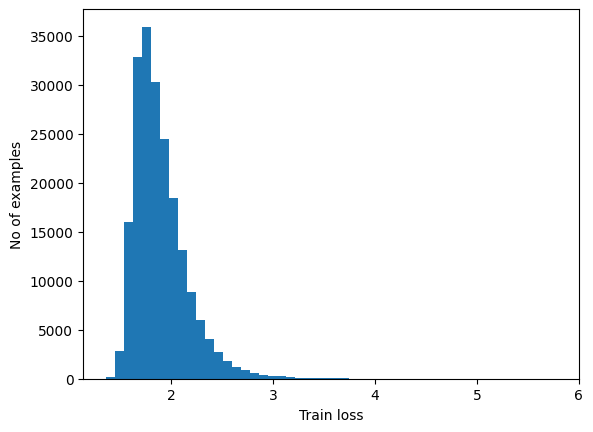

Threshold:  2.158532857527228


In [40]:
history = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(history, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

threshold = numpy.mean(train_loss) + numpy.std(train_loss)
print("Threshold: ", threshold)


6972/6972 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


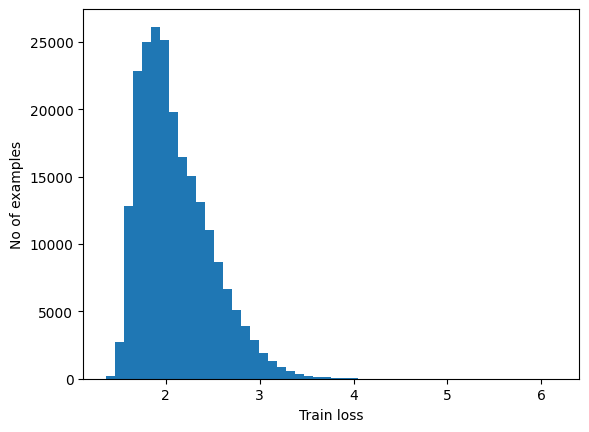

Threshold:  2.482736663451257


In [42]:
history = autoencoder.predict(eval_data)
train_loss = tf.keras.losses.mae(history, eval_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("eval loss")
plt.ylabel("No of examples")
plt.show()

threshold = numpy.mean(train_loss) + numpy.std(train_loss)
print("Threshold: ", threshold)

In [43]:
# classify as anomaly if the reconstruction error is greater than threshold

def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

predictions = predict(autoencoder, eval_data, threshold)
print_stats(predictions, eval_labels)

6972/6972 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


ValueError: Found input variables with inconsistent numbers of samples: [722, 223098]

6316/6316 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


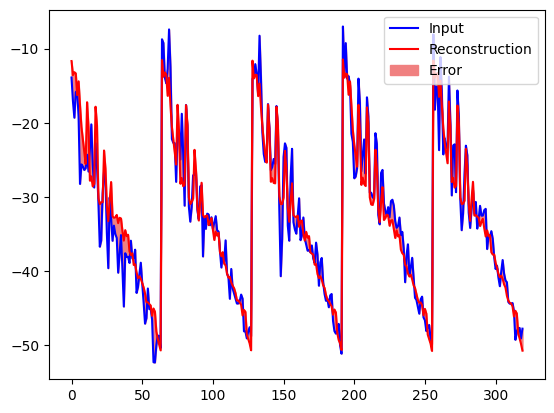

In [27]:
# reconstruct the error
import matplotlib.pyplot as plt
import numpy as np

encoded_data = encoder.predict(train_data)
decoded_data = decoder.predict(encoded_data)
train_loss = tf.keras.losses.mae(decoded_data, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

plt.plot(train_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(320), decoded_data[0], train_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

6972/6972 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


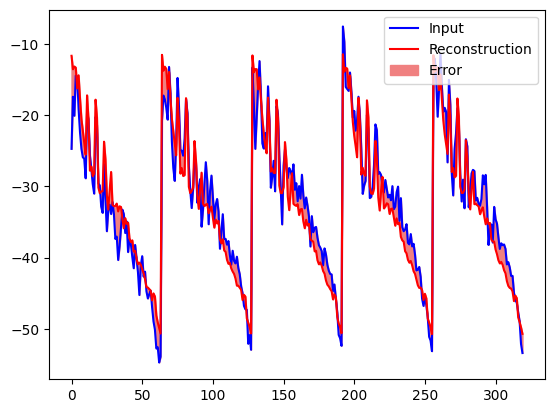

In [28]:
encoded_data1 = encoder.predict(eval_data)
decoded_data1 = decoder.predict(encoded_data)

plt.plot(eval_data[0], 'b')
plt.plot(decoded_data1[0], 'r')
plt.fill_between(np.arange(320), decoded_data1[0], eval_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


In [ ]:
from datapreprocessing import *
from datasetgenerator import *
from tqdm import tqdm

y_pred = [0. for k in eval_labels]
y_true = eval_labels

for num, file_name in tqdm(enumerate(eval_files), total=len(eval_files)):
  try:
    data = file_to_vector_array(file_name)
    error = numpy.mean(numpy.square(data - model.predict(data)), axis=1)
    y_pred[num] = numpy.mean(error)
  except:
    logger.warning("File broken!!: {}".format(file_name))

from sklearn import metrics

score = metrics.roc_auc_score(y_true, y_pred)
metrics.preciion_recall_curve(y_true, y_pred)
metrics.f1_score(y_true, y_pred)



In [49]:
from sklearn import metrics

score = metrics.roc_auc_score(y_true, y_pred)
#metrics.accuracy_score(y_true, y_pred)
metrics.f1_score(y_true, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [34]:
from datapreprocessing import *
from datasetgenerator import *
from tqdm import tqdm

y_pred = [0. for k in eval_labels]
y_true = eval_labels

for num, file_name in tqdm(enumerate(eval_files), total=len(eval_files)):
  try:
    data = file_to_vector_array(file_name)
    error = numpy.mean(numpy.square(data - autoencoder.predict(data)), axis=1)
    y_pred[num] = numpy.mean(error)
  except:
    logger.warning("File broken!!: {}".format(file_name))

from sklearn import metrics

score = metrics.roc_auc_score(y_true, y_pred)


  0%|          | 0/722 [00:00<?, ?it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


  0%|          | 1/722 [00:01<19:42,  1.64s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 2/722 [00:01<10:38,  1.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 3/722 [00:02<08:07,  1.48it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 4/722 [00:02<06:23,  1.87it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 5/722 [00:03<05:24,  2.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 6/722 [00:03<04:39,  2.56it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 7/722 [00:03<04:19,  2.76it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 8/722 [00:03<04:07,  2.89it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 9/722 [00:04<03:40,  3.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  1%|▏         | 10/722 [00:04<03:30,  3.38it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 11/722 [00:04<03:33,  3.32it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 12/722 [00:04<03:11,  3.71it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 13/722 [00:05<03:04,  3.85it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 14/722 [00:05<02:48,  4.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 15/722 [00:05<02:38,  4.47it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 16/722 [00:05<02:32,  4.64it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 17/722 [00:05<02:32,  4.63it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 18/722 [00:06<02:24,  4.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  3%|▎         | 19/722 [00:06<02:23,  4.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 20/722 [00:06<02:17,  5.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 21/722 [00:06<02:14,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 22/722 [00:06<02:22,  4.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  3%|▎         | 23/722 [00:07<02:18,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  3%|▎         | 24/722 [00:07<02:11,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 25/722 [00:07<02:02,  5.70it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▎         | 26/722 [00:07<02:05,  5.56it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▎         | 27/722 [00:07<02:06,  5.49it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 28/722 [00:07<02:04,  5.56it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 29/722 [00:08<02:12,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 30/722 [00:08<02:10,  5.32it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 31/722 [00:08<02:07,  5.42it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 32/722 [00:08<02:04,  5.53it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▍         | 33/722 [00:08<02:09,  5.32it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 34/722 [00:09<02:10,  5.28it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▍         | 35/722 [00:09<02:11,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▍         | 36/722 [00:09<02:17,  4.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▌         | 37/722 [00:09<02:13,  5.11it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 38/722 [00:09<02:15,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 39/722 [00:10<02:15,  5.03it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 40/722 [00:10<02:09,  5.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 41/722 [00:10<02:08,  5.31it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▌         | 42/722 [00:10<02:06,  5.36it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▌         | 43/722 [00:10<02:14,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▌         | 44/722 [00:11<02:33,  4.42it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▌         | 45/722 [00:11<02:34,  4.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  6%|▋         | 46/722 [00:11<02:46,  4.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 47/722 [00:11<02:50,  3.97it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 48/722 [00:12<02:48,  3.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 49/722 [00:12<02:57,  3.79it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 50/722 [00:12<03:00,  3.72it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 51/722 [00:13<02:52,  3.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 52/722 [00:13<02:45,  4.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 53/722 [00:13<02:41,  4.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 54/722 [00:13<02:44,  4.07it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  8%|▊         | 55/722 [00:14<02:53,  3.84it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  8%|▊         | 56/722 [00:14<02:56,  3.78it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  8%|▊         | 57/722 [00:14<02:58,  3.73it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 58/722 [00:14<03:00,  3.68it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  8%|▊         | 59/722 [00:15<02:57,  3.74it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  8%|▊         | 60/722 [00:15<02:49,  3.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  8%|▊         | 61/722 [00:15<02:50,  3.88it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▊         | 62/722 [00:15<02:52,  3.82it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▊         | 63/722 [00:16<02:34,  4.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▉         | 64/722 [00:16<02:21,  4.65it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 65/722 [00:16<02:17,  4.77it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▉         | 66/722 [00:16<02:12,  4.97it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 67/722 [00:16<02:10,  5.02it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▉         | 68/722 [00:16<02:07,  5.12it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 69/722 [00:17<02:10,  5.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|▉         | 70/722 [00:17<02:10,  5.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|▉         | 71/722 [00:17<02:03,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 72/722 [00:17<01:59,  5.45it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 73/722 [00:17<02:00,  5.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|█         | 74/722 [00:18<02:02,  5.28it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|█         | 75/722 [00:18<01:55,  5.59it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 76/722 [00:18<02:00,  5.34it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 11%|█         | 77/722 [00:18<02:01,  5.31it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 11%|█         | 78/722 [00:18<02:03,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 79/722 [00:19<01:57,  5.49it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 11%|█         | 80/722 [00:19<02:01,  5.29it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 11%|█         | 81/722 [00:19<02:02,  5.25it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 82/722 [00:19<02:05,  5.11it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 11%|█▏        | 83/722 [00:19<02:04,  5.12it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 12%|█▏        | 84/722 [00:20<02:05,  5.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 85/722 [00:20<02:05,  5.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 12%|█▏        | 86/722 [00:20<02:02,  5.19it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 87/722 [00:20<02:05,  5.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 88/722 [00:20<02:02,  5.16it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 12%|█▏        | 89/722 [00:21<02:06,  5.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 90/722 [00:21<02:02,  5.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 91/722 [00:21<02:04,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 92/722 [00:21<02:01,  5.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 93/722 [00:21<02:03,  5.09it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 94/722 [00:21<02:04,  5.04it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 95/722 [00:22<02:04,  5.02it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 96/722 [00:22<01:59,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 13%|█▎        | 97/722 [00:22<01:59,  5.25it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 98/722 [00:22<01:56,  5.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 99/722 [00:22<01:57,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 100/722 [00:23<01:58,  5.25it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 101/722 [00:23<02:03,  5.04it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 102/722 [00:23<01:59,  5.19it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 103/722 [00:23<02:06,  4.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 104/722 [00:23<02:04,  4.96it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 15%|█▍        | 105/722 [00:24<02:03,  5.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 15%|█▍        | 106/722 [00:24<02:03,  5.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 107/722 [00:24<01:58,  5.20it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 15%|█▍        | 108/722 [00:24<01:56,  5.28it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 109/722 [00:24<01:59,  5.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 110/722 [00:25<01:54,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 15%|█▌        | 111/722 [00:25<01:55,  5.28it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 16%|█▌        | 112/722 [00:25<01:53,  5.38it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 113/722 [00:25<01:54,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 16%|█▌        | 114/722 [00:25<02:04,  4.87it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 16%|█▌        | 115/722 [00:26<02:09,  4.68it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 16%|█▌        | 116/722 [00:26<02:19,  4.36it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 16%|█▌        | 117/722 [00:26<02:17,  4.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 16%|█▋        | 118/722 [00:26<02:18,  4.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 119/722 [00:27<02:21,  4.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 17%|█▋        | 120/722 [00:27<02:17,  4.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 17%|█▋        | 121/722 [00:27<02:17,  4.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 17%|█▋        | 122/722 [00:27<02:27,  4.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 123/722 [00:28<02:26,  4.08it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 17%|█▋        | 124/722 [00:28<02:31,  3.96it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 125/722 [00:28<02:36,  3.82it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 17%|█▋        | 126/722 [00:28<02:43,  3.65it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|█▊        | 127/722 [00:29<02:31,  3.92it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|█▊        | 128/722 [00:29<02:28,  4.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|█▊        | 129/722 [00:29<02:24,  4.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 18%|█▊        | 130/722 [00:29<02:34,  3.84it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|█▊        | 131/722 [00:30<02:35,  3.80it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 18%|█▊        | 132/722 [00:30<02:46,  3.53it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 133/722 [00:30<02:41,  3.65it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|█▊        | 134/722 [00:31<02:45,  3.55it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▊        | 135/722 [00:31<02:32,  3.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 136/722 [00:31<02:14,  4.35it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 137/722 [00:31<02:11,  4.45it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|█▉        | 138/722 [00:31<02:05,  4.65it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|█▉        | 139/722 [00:32<02:00,  4.83it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|█▉        | 140/722 [00:32<02:00,  4.85it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|█▉        | 141/722 [00:32<01:53,  5.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|█▉        | 142/722 [00:32<01:52,  5.15it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|█▉        | 143/722 [00:32<01:51,  5.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 144/722 [00:32<01:49,  5.29it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 145/722 [00:33<01:56,  4.94it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|██        | 146/722 [00:33<01:55,  4.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|██        | 147/722 [00:33<01:51,  5.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|██        | 148/722 [00:33<01:48,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 149/722 [00:33<01:55,  4.98it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|██        | 150/722 [00:34<01:53,  5.04it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 151/722 [00:34<01:55,  4.93it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 152/722 [00:34<01:48,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|██        | 153/722 [00:34<01:48,  5.22it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|██▏       | 154/722 [00:34<01:47,  5.28it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 155/722 [00:35<01:47,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 156/722 [00:35<01:52,  5.04it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|██▏       | 157/722 [00:35<01:47,  5.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|██▏       | 158/722 [00:35<01:45,  5.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|██▏       | 159/722 [00:35<01:40,  5.59it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|██▏       | 160/722 [00:36<01:44,  5.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 161/722 [00:36<01:50,  5.08it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|██▏       | 162/722 [00:36<01:47,  5.19it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 163/722 [00:36<01:41,  5.49it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 23%|██▎       | 164/722 [00:36<01:44,  5.35it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 23%|██▎       | 165/722 [00:36<01:42,  5.43it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 166/722 [00:37<01:40,  5.52it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 167/722 [00:37<01:42,  5.41it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 168/722 [00:37<01:43,  5.34it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 169/722 [00:37<01:41,  5.47it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▎       | 170/722 [00:37<01:39,  5.57it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|██▎       | 171/722 [00:38<01:40,  5.47it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 172/722 [00:38<01:44,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|██▍       | 173/722 [00:38<01:47,  5.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|██▍       | 174/722 [00:38<01:42,  5.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 24%|██▍       | 175/722 [00:38<01:42,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|██▍       | 176/722 [00:39<01:45,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|██▍       | 177/722 [00:39<01:45,  5.16it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|██▍       | 178/722 [00:39<01:48,  5.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|██▍       | 179/722 [00:39<01:49,  4.97it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 25%|██▍       | 180/722 [00:39<01:47,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|██▌       | 181/722 [00:40<01:46,  5.07it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|██▌       | 182/722 [00:40<01:47,  5.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|██▌       | 183/722 [00:40<01:48,  4.96it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|██▌       | 184/722 [00:40<01:49,  4.92it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▌       | 185/722 [00:40<01:50,  4.84it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▌       | 186/722 [00:41<01:52,  4.76it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 26%|██▌       | 187/722 [00:41<01:50,  4.84it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▌       | 188/722 [00:41<01:54,  4.68it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▌       | 189/722 [00:41<01:55,  4.61it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 190/722 [00:42<02:06,  4.22it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▋       | 191/722 [00:42<02:03,  4.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 27%|██▋       | 192/722 [00:42<02:12,  4.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 193/722 [00:42<02:12,  3.98it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 194/722 [00:43<02:15,  3.88it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 195/722 [00:43<02:14,  3.93it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 196/722 [00:43<02:07,  4.11it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 197/722 [00:43<02:08,  4.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|██▋       | 198/722 [00:43<02:04,  4.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 199/722 [00:44<02:07,  4.09it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 200/722 [00:44<02:13,  3.92it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 201/722 [00:44<02:13,  3.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 202/722 [00:45<02:13,  3.89it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 28%|██▊       | 203/722 [00:45<02:15,  3.83it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 204/722 [00:45<02:18,  3.75it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 28%|██▊       | 205/722 [00:45<02:13,  3.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|██▊       | 206/722 [00:46<02:15,  3.82it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|██▊       | 207/722 [00:46<02:10,  3.96it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|██▉       | 208/722 [00:46<02:08,  4.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|██▉       | 209/722 [00:46<02:04,  4.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|██▉       | 210/722 [00:46<01:54,  4.46it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|██▉       | 211/722 [00:47<01:47,  4.76it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|██▉       | 212/722 [00:47<01:43,  4.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 213/722 [00:47<01:39,  5.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 30%|██▉       | 214/722 [00:47<01:40,  5.08it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 215/722 [00:47<01:39,  5.08it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 216/722 [00:48<01:37,  5.22it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 30%|███       | 217/722 [00:48<01:34,  5.32it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 218/722 [00:48<01:32,  5.44it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 219/722 [00:48<01:30,  5.56it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|███       | 220/722 [00:48<01:31,  5.50it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 221/722 [00:49<01:35,  5.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|███       | 222/722 [00:49<01:34,  5.28it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 223/722 [00:49<01:31,  5.44it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|███       | 224/722 [00:49<01:30,  5.48it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|███       | 225/722 [00:49<01:32,  5.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 226/722 [00:49<01:34,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 227/722 [00:50<01:34,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|███▏      | 228/722 [00:50<01:31,  5.43it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|███▏      | 229/722 [00:50<01:33,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|███▏      | 230/722 [00:50<01:34,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 231/722 [00:50<01:36,  5.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|███▏      | 232/722 [00:51<01:29,  5.45it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 233/722 [00:51<01:32,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|███▏      | 234/722 [00:51<01:31,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|███▎      | 235/722 [00:51<01:28,  5.53it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 236/722 [00:51<01:24,  5.75it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|███▎      | 237/722 [00:52<01:28,  5.50it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|███▎      | 238/722 [00:52<01:27,  5.51it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 239/722 [00:52<01:24,  5.69it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|███▎      | 240/722 [00:52<01:22,  5.87it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|███▎      | 241/722 [00:52<01:24,  5.69it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███▎      | 242/722 [00:52<01:27,  5.47it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███▎      | 243/722 [00:53<01:26,  5.51it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███▍      | 244/722 [00:53<01:26,  5.56it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███▍      | 245/722 [00:53<01:27,  5.43it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███▍      | 246/722 [00:53<01:27,  5.44it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███▍      | 247/722 [00:53<01:26,  5.46it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 248/722 [00:53<01:27,  5.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 249/722 [00:54<01:29,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███▍      | 250/722 [00:54<01:26,  5.47it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███▍      | 251/722 [00:54<01:26,  5.47it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 35%|███▍      | 252/722 [00:54<01:24,  5.53it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 253/722 [00:54<01:28,  5.29it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███▌      | 254/722 [00:55<01:25,  5.45it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███▌      | 255/722 [00:55<01:24,  5.52it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███▌      | 256/722 [00:55<01:23,  5.57it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|███▌      | 257/722 [00:55<01:25,  5.46it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|███▌      | 258/722 [00:55<01:21,  5.67it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 259/722 [00:56<01:25,  5.41it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 260/722 [00:56<01:26,  5.35it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|███▌      | 261/722 [00:56<01:25,  5.38it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|███▋      | 262/722 [00:56<01:26,  5.32it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▋      | 263/722 [00:56<01:30,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|███▋      | 264/722 [00:57<01:36,  4.76it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|███▋      | 265/722 [00:57<01:43,  4.40it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 37%|███▋      | 266/722 [00:57<01:38,  4.64it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|███▋      | 267/722 [00:57<01:42,  4.44it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|███▋      | 268/722 [00:57<01:47,  4.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|███▋      | 269/722 [00:58<01:56,  3.89it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|███▋      | 270/722 [00:58<01:53,  3.98it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 271/722 [00:58<01:48,  4.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 38%|███▊      | 272/722 [00:59<01:49,  4.12it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 38%|███▊      | 273/722 [00:59<01:51,  4.03it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 38%|███▊      | 274/722 [00:59<01:42,  4.35it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 38%|███▊      | 275/722 [00:59<01:46,  4.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 38%|███▊      | 276/722 [00:59<01:45,  4.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 38%|███▊      | 277/722 [01:00<01:47,  4.15it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▊      | 278/722 [01:00<01:47,  4.12it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▊      | 279/722 [01:00<01:51,  3.98it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 39%|███▉      | 280/722 [01:00<01:44,  4.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 39%|███▉      | 281/722 [01:01<01:40,  4.38it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 39%|███▉      | 282/722 [01:01<01:43,  4.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 283/722 [01:01<01:56,  3.76it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 39%|███▉      | 284/722 [01:01<01:59,  3.67it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 39%|███▉      | 285/722 [01:02<01:59,  3.65it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███▉      | 286/722 [01:02<02:34,  2.82it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|███▉      | 287/722 [01:03<04:07,  1.76it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███▉      | 288/722 [01:05<05:28,  1.32it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 289/722 [01:05<05:40,  1.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


 40%|████      | 290/722 [01:06<05:18,  1.36it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 40%|████      | 291/722 [01:06<04:20,  1.66it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 40%|████      | 292/722 [01:07<03:34,  2.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 41%|████      | 293/722 [01:07<03:16,  2.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 41%|████      | 294/722 [01:07<03:07,  2.28it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 295/722 [01:08<02:41,  2.65it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|████      | 296/722 [01:08<02:18,  3.08it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|████      | 297/722 [01:08<02:01,  3.49it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 298/722 [01:08<01:54,  3.71it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|████▏     | 299/722 [01:08<01:42,  4.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 42%|████▏     | 300/722 [01:09<01:32,  4.56it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 301/722 [01:09<01:26,  4.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 42%|████▏     | 302/722 [01:09<01:23,  5.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 42%|████▏     | 303/722 [01:09<01:21,  5.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 304/722 [01:09<01:22,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 42%|████▏     | 305/722 [01:10<01:24,  4.96it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 306/722 [01:10<01:24,  4.95it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 307/722 [01:10<01:21,  5.12it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 308/722 [01:10<01:18,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 309/722 [01:10<01:21,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 310/722 [01:11<01:21,  5.04it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 311/722 [01:11<01:18,  5.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 312/722 [01:11<01:15,  5.43it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 313/722 [01:11<01:16,  5.36it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 314/722 [01:11<01:18,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 44%|████▎     | 315/722 [01:11<01:17,  5.22it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 44%|████▍     | 316/722 [01:12<01:17,  5.25it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 44%|████▍     | 317/722 [01:12<01:19,  5.09it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 44%|████▍     | 318/722 [01:12<01:17,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 44%|████▍     | 319/722 [01:12<01:16,  5.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 320/722 [01:12<01:22,  4.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 321/722 [01:13<01:21,  4.94it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|████▍     | 322/722 [01:13<01:20,  4.94it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 323/722 [01:13<01:21,  4.91it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 324/722 [01:13<01:15,  5.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|████▌     | 325/722 [01:13<01:18,  5.04it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|████▌     | 326/722 [01:14<01:18,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|████▌     | 327/722 [01:14<01:16,  5.19it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|████▌     | 328/722 [01:14<01:12,  5.40it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████▌     | 329/722 [01:14<01:14,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 46%|████▌     | 330/722 [01:14<01:30,  4.35it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 331/722 [01:15<01:28,  4.41it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████▌     | 332/722 [01:15<01:31,  4.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████▌     | 333/722 [01:15<01:36,  4.03it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████▋     | 334/722 [01:16<01:40,  3.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 46%|████▋     | 335/722 [01:16<01:35,  4.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|████▋     | 336/722 [01:16<01:31,  4.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|████▋     | 337/722 [01:16<01:33,  4.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|████▋     | 338/722 [01:16<01:30,  4.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|████▋     | 339/722 [01:17<01:34,  4.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 340/722 [01:17<01:35,  3.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 341/722 [01:17<01:38,  3.87it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 342/722 [01:18<01:40,  3.78it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 48%|████▊     | 343/722 [01:18<01:42,  3.70it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 48%|████▊     | 344/722 [01:18<01:39,  3.81it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 48%|████▊     | 345/722 [01:18<01:33,  4.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 346/722 [01:19<01:33,  4.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 48%|████▊     | 347/722 [01:19<01:35,  3.93it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 348/722 [01:19<01:36,  3.89it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 48%|████▊     | 349/722 [01:19<01:35,  3.89it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 48%|████▊     | 350/722 [01:20<01:32,  4.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▊     | 351/722 [01:20<01:34,  3.91it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 352/722 [01:20<01:32,  4.02it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 353/722 [01:20<01:28,  4.19it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 354/722 [01:20<01:24,  4.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 355/722 [01:21<01:18,  4.68it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 356/722 [01:21<01:17,  4.71it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 357/722 [01:21<01:13,  4.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|████▉     | 358/722 [01:21<01:14,  4.92it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|████▉     | 359/722 [01:21<01:12,  4.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|████▉     | 360/722 [01:22<01:08,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|█████     | 361/722 [01:22<01:06,  5.44it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 362/722 [01:22<01:07,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|█████     | 363/722 [01:22<01:07,  5.35it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|█████     | 364/722 [01:22<01:07,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 365/722 [01:23<01:10,  5.04it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 366/722 [01:23<01:11,  5.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 51%|█████     | 367/722 [01:23<01:10,  5.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 368/722 [01:23<01:09,  5.12it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 369/722 [01:23<01:09,  5.09it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████     | 370/722 [01:24<01:08,  5.11it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████▏    | 371/722 [01:24<01:09,  5.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 52%|█████▏    | 372/722 [01:24<01:06,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 52%|█████▏    | 373/722 [01:24<01:08,  5.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 374/722 [01:24<01:08,  5.07it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 52%|█████▏    | 375/722 [01:25<01:09,  4.97it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 376/722 [01:25<01:05,  5.32it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 377/722 [01:25<01:09,  4.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 378/722 [01:25<01:12,  4.74it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 52%|█████▏    | 379/722 [01:25<01:11,  4.81it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 380/722 [01:26<01:07,  5.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 53%|█████▎    | 381/722 [01:26<01:07,  5.03it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 53%|█████▎    | 382/722 [01:26<01:37,  3.50it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 383/722 [01:26<01:36,  3.52it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 53%|█████▎    | 384/722 [01:27<01:24,  3.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 53%|█████▎    | 385/722 [01:27<01:16,  4.42it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 53%|█████▎    | 386/722 [01:27<01:11,  4.71it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 54%|█████▎    | 387/722 [01:27<01:08,  4.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 54%|█████▎    | 388/722 [01:27<01:05,  5.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 54%|█████▍    | 389/722 [01:28<01:05,  5.09it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 54%|█████▍    | 390/722 [01:28<01:05,  5.09it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 54%|█████▍    | 391/722 [01:28<01:04,  5.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 54%|█████▍    | 392/722 [01:28<01:03,  5.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 54%|█████▍    | 393/722 [01:28<01:03,  5.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 394/722 [01:29<01:03,  5.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|█████▍    | 395/722 [01:29<01:02,  5.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 55%|█████▍    | 396/722 [01:29<01:02,  5.22it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 397/722 [01:29<01:03,  5.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 55%|█████▌    | 398/722 [01:29<01:04,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|█████▌    | 399/722 [01:30<01:02,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 400/722 [01:30<00:59,  5.41it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 56%|█████▌    | 401/722 [01:30<01:00,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|█████▌    | 402/722 [01:30<01:02,  5.16it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 56%|█████▌    | 403/722 [01:30<01:07,  4.75it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|█████▌    | 404/722 [01:31<01:10,  4.51it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 56%|█████▌    | 405/722 [01:31<01:13,  4.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 56%|█████▌    | 406/722 [01:31<01:18,  4.03it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|█████▋    | 407/722 [01:31<01:16,  4.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 57%|█████▋    | 408/722 [01:32<01:16,  4.09it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 57%|█████▋    | 409/722 [01:32<01:16,  4.09it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████▋    | 410/722 [01:32<01:15,  4.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████▋    | 411/722 [01:32<01:18,  3.97it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 412/722 [01:33<01:19,  3.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████▋    | 413/722 [01:33<01:19,  3.89it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████▋    | 414/722 [01:33<01:14,  4.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████▋    | 415/722 [01:33<01:17,  3.96it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 58%|█████▊    | 416/722 [01:34<01:20,  3.81it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 58%|█████▊    | 417/722 [01:34<01:21,  3.75it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 58%|█████▊    | 418/722 [01:34<01:20,  3.75it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 58%|█████▊    | 419/722 [01:34<01:17,  3.93it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 58%|█████▊    | 420/722 [01:35<01:18,  3.83it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 58%|█████▊    | 421/722 [01:35<01:16,  3.92it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 58%|█████▊    | 422/722 [01:35<01:18,  3.83it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 59%|█████▊    | 423/722 [01:35<01:20,  3.72it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 59%|█████▊    | 424/722 [01:36<01:18,  3.80it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 59%|█████▉    | 425/722 [01:36<01:16,  3.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 426/722 [01:36<01:15,  3.93it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 427/722 [01:36<01:12,  4.04it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 59%|█████▉    | 428/722 [01:37<01:07,  4.36it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 59%|█████▉    | 429/722 [01:37<01:04,  4.52it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 60%|█████▉    | 430/722 [01:37<01:00,  4.82it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 60%|█████▉    | 431/722 [01:37<00:59,  4.87it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 432/722 [01:37<01:00,  4.77it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 60%|█████▉    | 433/722 [01:38<00:59,  4.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 60%|██████    | 434/722 [01:38<00:57,  4.97it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 60%|██████    | 435/722 [01:38<00:56,  5.07it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 60%|██████    | 436/722 [01:38<00:56,  5.07it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████    | 437/722 [01:38<00:57,  4.92it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████    | 438/722 [01:39<00:57,  4.98it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████    | 439/722 [01:39<00:58,  4.83it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████    | 440/722 [01:39<00:58,  4.84it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████    | 441/722 [01:39<00:56,  5.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 442/722 [01:39<00:56,  4.96it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████▏   | 443/722 [01:40<00:55,  5.02it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|██████▏   | 444/722 [01:40<00:54,  5.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|██████▏   | 445/722 [01:40<00:53,  5.15it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 62%|██████▏   | 446/722 [01:40<00:53,  5.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 62%|██████▏   | 447/722 [01:40<00:53,  5.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 448/722 [01:41<00:51,  5.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 62%|██████▏   | 449/722 [01:41<00:50,  5.38it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 450/722 [01:41<00:51,  5.29it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 62%|██████▏   | 451/722 [01:41<00:52,  5.20it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 63%|██████▎   | 452/722 [01:41<01:02,  4.34it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


 63%|██████▎   | 453/722 [01:42<01:37,  2.76it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 454/722 [01:42<01:32,  2.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 455/722 [01:43<01:17,  3.45it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 63%|██████▎   | 456/722 [01:43<01:07,  3.91it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████▎   | 457/722 [01:43<01:02,  4.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████▎   | 458/722 [01:43<00:58,  4.48it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|██████▎   | 459/722 [01:43<00:55,  4.72it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 64%|██████▎   | 460/722 [01:44<00:52,  4.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 64%|██████▍   | 461/722 [01:44<00:52,  5.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 64%|██████▍   | 462/722 [01:44<00:50,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 64%|██████▍   | 463/722 [01:44<00:49,  5.22it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 64%|██████▍   | 464/722 [01:44<00:50,  5.15it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 64%|██████▍   | 465/722 [01:44<00:50,  5.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|██████▍   | 466/722 [01:45<00:49,  5.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 65%|██████▍   | 467/722 [01:45<00:47,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 65%|██████▍   | 468/722 [01:45<00:48,  5.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 65%|██████▍   | 469/722 [01:45<00:48,  5.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 470/722 [01:45<00:48,  5.20it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 65%|██████▌   | 471/722 [01:46<00:48,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 65%|██████▌   | 472/722 [01:46<00:47,  5.29it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 66%|██████▌   | 473/722 [01:46<00:47,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 474/722 [01:46<00:52,  4.71it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|██████▌   | 475/722 [01:47<00:57,  4.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|██████▌   | 476/722 [01:47<00:58,  4.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 66%|██████▌   | 477/722 [01:47<00:56,  4.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 478/722 [01:47<01:00,  4.02it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 66%|██████▋   | 479/722 [01:48<01:01,  3.97it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 66%|██████▋   | 480/722 [01:48<00:59,  4.04it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 67%|██████▋   | 481/722 [01:48<00:58,  4.12it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 67%|██████▋   | 482/722 [01:48<00:57,  4.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 67%|██████▋   | 483/722 [01:49<00:59,  4.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 67%|██████▋   | 484/722 [01:49<00:55,  4.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 67%|██████▋   | 485/722 [01:49<00:57,  4.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 67%|██████▋   | 486/722 [01:49<00:56,  4.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 67%|██████▋   | 487/722 [01:50<00:58,  4.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 68%|██████▊   | 488/722 [01:50<01:01,  3.79it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 489/722 [01:50<01:00,  3.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 490/722 [01:50<00:59,  3.93it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 68%|██████▊   | 491/722 [01:51<00:57,  3.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 68%|██████▊   | 492/722 [01:51<00:59,  3.84it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 493/722 [01:51<00:59,  3.82it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 494/722 [01:51<01:03,  3.57it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 69%|██████▊   | 495/722 [01:52<01:00,  3.73it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 69%|██████▊   | 496/722 [01:52<01:01,  3.70it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 69%|██████▉   | 497/722 [01:52<00:55,  4.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 69%|██████▉   | 498/722 [01:52<00:51,  4.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 69%|██████▉   | 499/722 [01:53<00:49,  4.50it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 500/722 [01:53<00:46,  4.75it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 69%|██████▉   | 501/722 [01:53<00:45,  4.85it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 502/722 [01:53<00:45,  4.84it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|██████▉   | 503/722 [01:53<00:43,  5.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|██████▉   | 504/722 [01:53<00:44,  4.89it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|██████▉   | 505/722 [01:54<00:42,  5.07it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 506/722 [01:54<00:41,  5.15it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 70%|███████   | 507/722 [01:54<00:41,  5.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 508/722 [01:54<00:40,  5.34it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 509/722 [01:54<00:40,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 71%|███████   | 510/722 [01:55<00:41,  5.12it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|███████   | 511/722 [01:55<00:41,  5.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 71%|███████   | 512/722 [01:55<00:40,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 71%|███████   | 513/722 [01:55<00:40,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 71%|███████   | 514/722 [01:55<00:39,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 71%|███████▏  | 515/722 [01:56<00:39,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 71%|███████▏  | 516/722 [01:56<00:39,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 517/722 [01:56<00:39,  5.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 72%|███████▏  | 518/722 [01:56<00:39,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|███████▏  | 519/722 [01:56<00:38,  5.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 72%|███████▏  | 520/722 [01:57<00:38,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 72%|███████▏  | 521/722 [01:57<00:40,  5.02it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 72%|███████▏  | 522/722 [01:57<00:39,  5.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 72%|███████▏  | 523/722 [01:57<00:39,  5.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|███████▎  | 524/722 [01:57<00:39,  5.07it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 73%|███████▎  | 525/722 [01:58<00:37,  5.25it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 73%|███████▎  | 526/722 [01:58<00:36,  5.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 73%|███████▎  | 527/722 [01:58<00:37,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 73%|███████▎  | 528/722 [01:58<00:36,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 529/722 [01:58<00:34,  5.57it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 530/722 [01:58<00:36,  5.32it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 74%|███████▎  | 531/722 [01:59<00:34,  5.49it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 74%|███████▎  | 532/722 [01:59<00:33,  5.64it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 74%|███████▍  | 533/722 [01:59<00:34,  5.41it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 74%|███████▍  | 534/722 [01:59<00:35,  5.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 535/722 [01:59<00:34,  5.37it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 74%|███████▍  | 536/722 [02:00<00:34,  5.41it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 74%|███████▍  | 537/722 [02:00<00:34,  5.41it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 75%|███████▍  | 538/722 [02:00<00:33,  5.54it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 75%|███████▍  | 539/722 [02:00<00:33,  5.46it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 75%|███████▍  | 540/722 [02:00<00:32,  5.62it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 541/722 [02:00<00:33,  5.36it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 75%|███████▌  | 542/722 [02:01<00:33,  5.41it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 75%|███████▌  | 543/722 [02:01<00:32,  5.45it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 75%|███████▌  | 544/722 [02:01<00:32,  5.46it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 75%|███████▌  | 545/722 [02:01<00:32,  5.51it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 546/722 [02:01<00:32,  5.45it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 76%|███████▌  | 547/722 [02:02<00:32,  5.40it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 76%|███████▌  | 548/722 [02:02<00:32,  5.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|███████▌  | 549/722 [02:02<00:32,  5.36it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 76%|███████▌  | 550/722 [02:02<00:35,  4.91it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 76%|███████▋  | 551/722 [02:02<00:38,  4.46it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|███████▋  | 552/722 [02:03<00:39,  4.34it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|███████▋  | 553/722 [02:03<00:40,  4.16it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 554/722 [02:03<00:39,  4.28it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|███████▋  | 555/722 [02:03<00:39,  4.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 77%|███████▋  | 556/722 [02:04<00:36,  4.51it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 77%|███████▋  | 557/722 [02:04<00:38,  4.29it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 558/722 [02:04<00:39,  4.12it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 77%|███████▋  | 559/722 [02:04<00:39,  4.11it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 560/722 [02:05<00:38,  4.19it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 78%|███████▊  | 561/722 [02:05<00:38,  4.15it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 562/722 [02:05<00:36,  4.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 563/722 [02:05<00:38,  4.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|███████▊  | 564/722 [02:06<00:37,  4.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 565/722 [02:06<00:37,  4.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 78%|███████▊  | 566/722 [02:06<00:38,  4.10it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████▊  | 567/722 [02:06<00:39,  3.97it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 79%|███████▊  | 568/722 [02:07<00:38,  3.99it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 569/722 [02:07<00:37,  4.05it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 79%|███████▉  | 570/722 [02:07<00:42,  3.56it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 571/722 [02:07<00:41,  3.67it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 79%|███████▉  | 572/722 [02:08<00:40,  3.74it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 79%|███████▉  | 573/722 [02:08<00:37,  3.95it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 80%|███████▉  | 574/722 [02:08<00:33,  4.38it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 80%|███████▉  | 575/722 [02:08<00:31,  4.66it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 576/722 [02:08<00:30,  4.82it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 80%|███████▉  | 577/722 [02:09<00:28,  5.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 80%|████████  | 578/722 [02:09<00:27,  5.32it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 80%|████████  | 579/722 [02:09<00:26,  5.42it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 80%|████████  | 580/722 [02:09<00:26,  5.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 80%|████████  | 581/722 [02:09<00:26,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 81%|████████  | 582/722 [02:10<00:27,  5.16it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 81%|████████  | 583/722 [02:10<00:26,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 584/722 [02:10<00:26,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 81%|████████  | 585/722 [02:10<00:26,  5.21it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████  | 586/722 [02:10<00:25,  5.25it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 587/722 [02:11<00:26,  5.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 81%|████████▏ | 588/722 [02:11<00:26,  5.13it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 82%|████████▏ | 589/722 [02:11<00:24,  5.42it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|████████▏ | 590/722 [02:11<00:24,  5.47it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 82%|████████▏ | 591/722 [02:11<00:24,  5.41it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 592/722 [02:11<00:24,  5.25it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 82%|████████▏ | 593/722 [02:12<00:25,  5.15it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 82%|████████▏ | 594/722 [02:12<00:24,  5.22it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 82%|████████▏ | 595/722 [02:12<00:23,  5.43it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 83%|████████▎ | 596/722 [02:12<00:23,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 83%|████████▎ | 597/722 [02:12<00:23,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 83%|████████▎ | 598/722 [02:13<00:23,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|████████▎ | 599/722 [02:13<00:22,  5.42it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 83%|████████▎ | 600/722 [02:13<00:21,  5.61it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 83%|████████▎ | 601/722 [02:13<00:21,  5.73it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 83%|████████▎ | 602/722 [02:13<00:21,  5.59it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 84%|████████▎ | 603/722 [02:13<00:21,  5.57it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▎ | 604/722 [02:14<00:21,  5.43it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 605/722 [02:14<00:21,  5.36it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 606/722 [02:14<00:21,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 607/722 [02:14<00:20,  5.49it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 608/722 [02:14<00:21,  5.29it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 84%|████████▍ | 609/722 [02:15<00:20,  5.45it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 610/722 [02:15<00:21,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 85%|████████▍ | 611/722 [02:15<00:21,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▍ | 612/722 [02:15<00:20,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▍ | 613/722 [02:15<00:20,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 85%|████████▌ | 614/722 [02:16<00:20,  5.28it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▌ | 615/722 [02:16<00:19,  5.42it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|████████▌ | 616/722 [02:16<00:19,  5.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 85%|████████▌ | 617/722 [02:16<00:19,  5.28it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 618/722 [02:16<00:18,  5.51it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 619/722 [02:16<00:19,  5.23it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 86%|████████▌ | 620/722 [02:17<00:19,  5.29it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 86%|████████▌ | 621/722 [02:17<00:19,  5.09it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 86%|████████▌ | 622/722 [02:17<00:19,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 86%|████████▋ | 623/722 [02:17<00:18,  5.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 624/722 [02:17<00:18,  5.25it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 87%|████████▋ | 625/722 [02:18<00:18,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 87%|████████▋ | 626/722 [02:18<00:18,  5.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 87%|████████▋ | 627/722 [02:18<00:20,  4.56it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 87%|████████▋ | 628/722 [02:18<00:23,  4.04it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 87%|████████▋ | 629/722 [02:19<00:21,  4.31it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 87%|████████▋ | 630/722 [02:19<00:20,  4.46it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 87%|████████▋ | 631/722 [02:19<00:19,  4.61it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 88%|████████▊ | 632/722 [02:19<00:20,  4.35it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 88%|████████▊ | 633/722 [02:20<00:20,  4.31it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 88%|████████▊ | 634/722 [02:20<00:20,  4.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 635/722 [02:20<00:20,  4.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 88%|████████▊ | 636/722 [02:20<00:20,  4.19it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 88%|████████▊ | 637/722 [02:20<00:19,  4.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 88%|████████▊ | 638/722 [02:21<00:20,  4.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 89%|████████▊ | 639/722 [02:21<00:21,  3.84it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▊ | 640/722 [02:21<00:21,  3.88it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 89%|████████▉ | 641/722 [02:22<00:20,  3.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 89%|████████▉ | 642/722 [02:22<00:20,  3.87it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 89%|████████▉ | 643/722 [02:22<00:20,  3.87it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 89%|████████▉ | 644/722 [02:22<00:20,  3.75it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 89%|████████▉ | 645/722 [02:23<00:19,  3.94it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 89%|████████▉ | 646/722 [02:23<00:19,  3.90it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 90%|████████▉ | 647/722 [02:23<00:19,  3.80it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 90%|████████▉ | 648/722 [02:23<00:19,  3.88it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 90%|████████▉ | 649/722 [02:24<00:18,  3.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 650/722 [02:24<00:17,  4.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 90%|█████████ | 651/722 [02:24<00:15,  4.46it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 652/722 [02:24<00:14,  4.75it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 90%|█████████ | 653/722 [02:24<00:14,  4.91it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 91%|█████████ | 654/722 [02:25<00:13,  5.08it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████ | 655/722 [02:25<00:13,  5.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 91%|█████████ | 656/722 [02:25<00:12,  5.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████ | 657/722 [02:25<00:13,  4.97it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 91%|█████████ | 658/722 [02:25<00:12,  5.11it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████▏| 659/722 [02:26<00:11,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████▏| 660/722 [02:26<00:11,  5.24it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 92%|█████████▏| 661/722 [02:26<00:11,  5.44it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 92%|█████████▏| 662/722 [02:26<00:11,  5.34it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 663/722 [02:26<00:11,  5.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 92%|█████████▏| 664/722 [02:26<00:10,  5.30it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 92%|█████████▏| 665/722 [02:27<00:10,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 92%|█████████▏| 666/722 [02:27<00:10,  5.31it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 92%|█████████▏| 667/722 [02:27<00:10,  5.36it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 93%|█████████▎| 668/722 [02:27<00:10,  5.31it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 93%|█████████▎| 669/722 [02:27<00:10,  4.89it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 93%|█████████▎| 670/722 [02:28<00:10,  5.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 93%|█████████▎| 671/722 [02:28<00:09,  5.14it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 93%|█████████▎| 672/722 [02:28<00:09,  5.18it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 93%|█████████▎| 673/722 [02:28<00:09,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 674/722 [02:28<00:08,  5.48it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 93%|█████████▎| 675/722 [02:29<00:08,  5.44it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 94%|█████████▎| 676/722 [02:29<00:08,  5.65it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 94%|█████████▍| 677/722 [02:29<00:07,  5.67it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▍| 678/722 [02:29<00:07,  5.53it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▍| 679/722 [02:29<00:07,  5.43it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 680/722 [02:29<00:08,  5.20it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 94%|█████████▍| 681/722 [02:30<00:07,  5.32it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 94%|█████████▍| 682/722 [02:30<00:07,  5.34it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 95%|█████████▍| 683/722 [02:30<00:07,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 95%|█████████▍| 684/722 [02:30<00:07,  5.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 685/722 [02:30<00:06,  5.34it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 95%|█████████▌| 686/722 [02:31<00:06,  5.39it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 95%|█████████▌| 687/722 [02:31<00:06,  5.42it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 688/722 [02:31<00:05,  5.69it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 95%|█████████▌| 689/722 [02:31<00:06,  5.46it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 96%|█████████▌| 690/722 [02:31<00:05,  5.45it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 691/722 [02:32<00:06,  4.94it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 96%|█████████▌| 692/722 [02:32<00:05,  5.03it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 96%|█████████▌| 693/722 [02:32<00:05,  5.03it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 96%|█████████▌| 694/722 [02:32<00:05,  5.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 96%|█████████▋| 695/722 [02:32<00:05,  5.08it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 96%|█████████▋| 696/722 [02:33<00:05,  5.17it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 97%|█████████▋| 697/722 [02:33<00:04,  5.20it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 97%|█████████▋| 698/722 [02:33<00:04,  5.19it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 97%|█████████▋| 699/722 [02:33<00:04,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 97%|█████████▋| 700/722 [02:33<00:04,  5.27it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 97%|█████████▋| 701/722 [02:33<00:03,  5.33it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 97%|█████████▋| 702/722 [02:34<00:03,  5.26it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 97%|█████████▋| 703/722 [02:34<00:03,  5.29it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 98%|█████████▊| 704/722 [02:34<00:03,  5.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 98%|█████████▊| 705/722 [02:34<00:04,  4.06it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 98%|█████████▊| 706/722 [02:35<00:04,  3.78it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 707/722 [02:35<00:03,  3.85it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 98%|█████████▊| 708/722 [02:35<00:03,  3.85it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 98%|█████████▊| 709/722 [02:36<00:03,  3.49it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 98%|█████████▊| 710/722 [02:36<00:03,  3.56it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 711/722 [02:36<00:02,  3.71it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 712/722 [02:36<00:02,  4.00it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 99%|█████████▉| 713/722 [02:37<00:02,  4.01it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 714/722 [02:37<00:02,  3.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 99%|█████████▉| 715/722 [02:37<00:01,  3.96it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 716/722 [02:37<00:01,  4.07it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 99%|█████████▉| 717/722 [02:38<00:01,  3.89it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 99%|█████████▉| 718/722 [02:38<00:01,  3.80it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


100%|█████████▉| 719/722 [02:38<00:00,  3.86it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


100%|█████████▉| 720/722 [02:38<00:00,  3.66it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 721/722 [02:39<00:00,  3.70it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|██████████| 722/722 [02:39<00:00,  4.53it/s]


In [35]:
score

0.878653478717935

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy = {}".format(accuracy_score(y_true, y_pred)))
print("Precision = {}".format(precision_score(y_true, y_pred)))
print("Recall = {}".format(recall_score(y_true, y_pred)))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
encoded_data = autoencoder.encoder(test_data_np).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

# Get the length of the data for the x-axis
data_length = len(test_data_np[0])

# Use data_length instead of np.arange(140)
plt.plot(test_data_np[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(data_length), decoded_data[0], test_data_np[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
encoded_data = autoencoder.encoder(train_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(eval_files[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(320), decoded_data[0], train_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
# create a class and functions with 3-4 models for experiments

class experiment_class(Model):
  def __init__(self):
    super(experiment_class, self).__init__()
    self.model1 = keras_model_base(input_dim)
    self.model2 = keras_model_encoder(input_dim)
    self.model3 = tf_model(input_dim)
    self.model4 = tf_model(input_dim)

    def model1_train(self, train_data, eval_data):
      self.model1 = tf.keras.Sequential([
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu")])
      self.model1.compile(optimizer='adam', loss='mse')
      training = self.model1.fit(train_data, train_data,
                                 epochs=10,
                                 batch_size=32,
                                 validation_data=(eval_data, eval_data),
                                 shuffle=True)

